# compare two model using F-test
model1: $y(t) = ky(t-h) + x(t)\beta + \epsilon$ 
- where the spikes in X are smoothed by a gaussian kernel

model2: $y(t) = ky(t-h) + \epsilon$

In [1]:
import pickle
from pathlib import Path
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns

from param import *

sns.set_theme(style="whitegrid")

ROOT = "/work/"
DATA_ROOT = ROOT/Path('data/alldata/')
OUTPUT_ROOT = ROOT/Path("output/")

datalist = np.array([x for x in DATA_ROOT.iterdir()])
output_dir = OUTPUT_ROOT/"ridge_regression/"

In [2]:
def get_RSS(results_all: list, nthist: int, axis: str, **kwargs):
    """Get RSS and degree of freedom."""
    if kwargs["window_size"]:
        filtered_result = [result for result in results_all if (result["nthist"]==nthist)and(result["coord_axis"]==axis)and(result["window_size"]==kwargs["window_size"])][0]
    else:
        filtered_result = [result for result in results_all if (result["nthist"]==nthist)and(result["coord_axis"]==axis)][0]
    rss = filtered_result['sig_tests'].RSS
    df = filtered_result['sig_tests'].df_model
    return rss, df

def cal_f_stat(rss1, rss2, df1, df2):
    """Cal the F statistics and corresponding p-value."""
    tmp1 = (rss2 - rss1)/df2
    tmp2 = rss1/df1
    f_stat = tmp1/tmp2
    return f_stat, stats.f.sf(f_stat, df2, df1)

def gen_df(data_dir, model_type: str):
    data_name = str(data_dir).split('/')[-1]
    mouse_type = "knockout" if "CaMKII" in data_name else "wild-type"

    if model_type == "smoothed":
        # smoothed spikes + past coord
        with open(output_dir/(f"rr_smoothed_spikes_eval_{data_name}.pickle"),"rb") as f:
            sp_results_all = pickle.load(f)
    elif model_type == "past-coord":
        # spikes+ past coord
        with open(output_dir/(f"rr_spikes_past_coord_eval_{data_name}.pickle"),"rb") as f:
            sp_results_all = pickle.load(f)

    # only past-coord
    with open(output_dir/(f"rr_only_past_coord_eval_{data_name}.pickle"),"rb") as f:
        op_results_all = pickle.load(f)

    f_p_list = []
    f_stat_list = []
    for window_size in ParamData().window_size_range:
        axis = "x-axis"
        nthist = 5
        if model_type == "smoothed":
            rss1, df1 = get_RSS(sp_results_all ,nthist, axis, window_size = window_size)
        if model_type == "past-coord":
            rss1, df1 = get_RSS(sp_results_all ,nthist, axis, window_size = None)
        rss2, df2 = get_RSS(op_results_all ,nthist, axis, window_size = None)
        f_stat, f_p_value = cal_f_stat(rss1, rss2, df1, df2)
        f_p_list.append(f_p_value)
        f_stat_list.append(round(f_stat, 2))
    df = pd.DataFrame({
        "window size": ParamData().window_size_range,
        "F test p value": f_p_list,
        "F statistics": f_stat_list
        })
    return df

## Representatives

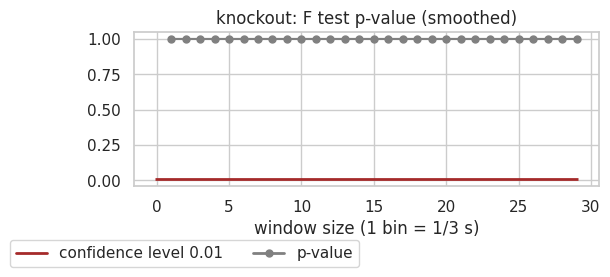

In [3]:
confidence_level = .01
model_type = "smoothed"
for data_dir in datalist[[0]]:
    data_name = str(data_dir).split('/')[-1]
    mouse_type = "knockout" if "CaMKII" in data_name else "wild-type"
    df = gen_df(data_dir, model_type)
    fig, ax = plt.subplots(figsize=(6,2))
    df.set_index("window size")[["F test p value"]].plot(ax=ax, color="gray", marker="o", markersize=5)
    ax.hlines(y=confidence_level, xmin=min(df.index)-.1, xmax=max(df.index)+1.1, colors="brown", lw=2)
    ax.get_legend().remove()
    ax.set_title(f"{mouse_type}: F test p-value ({model_type})")
    ax.set_xlabel("window size (1 bin = 1/3 s)")

    legend_elements = [
                    Line2D([0], [0], lw=2, label=f'confidence level {confidence_level}', color='brown'),
                    Line2D([0], [0], lw=2, label='p-value', color='gray', marker='o', markersize=5)
                    ]
    ax.legend(handles=legend_elements, bbox_to_anchor=(.5,-.3), ncol=2)
        

## All mice

Text(0.5, 0.98, 'confidence level:0.01, nthist: 5')

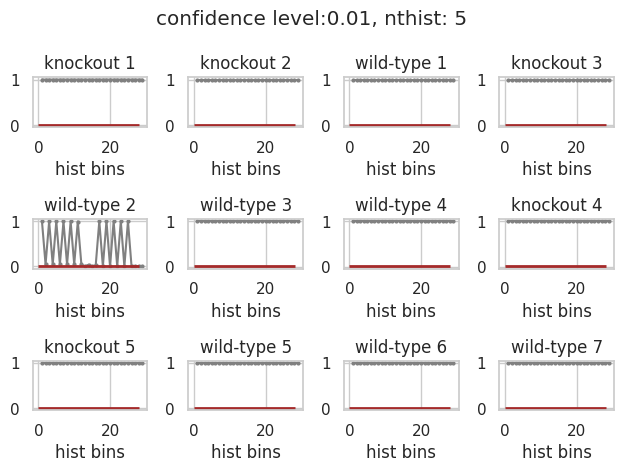

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, tight_layout = True)
axes = axes.ravel()
ko_id, wt_id = 0, 0
conf_level = .01
model_type = "smoothed"
nthist = 5
for mouse_id, data_dir in enumerate(datalist):
    ax = axes[mouse_id]
    data_name = str(data_dir).split('/')[-1]
    if "CaMKII" in data_name:
        mouse_type = "knockout" 
        ko_id += 1
        ax.set_title(f"{mouse_type} {ko_id}")
    else:
        mouse_type = "wild-type"
        wt_id += 1
        ax.set_title(f"{mouse_type} {wt_id}")
    df = gen_df(data_dir, model_type)
    df.set_index("window size")[["F test p value"]].plot(ax=ax, color="gray", marker="o", markersize=2)
    ax.hlines(y=conf_level, xmin=min(df.index)-.1, xmax=max(df.index)+.1, colors="brown", lw=2)
    ax.get_legend().remove()
    ax.set_xlabel("hist bins")
plt.suptitle(f"confidence level:{conf_level}, nthist: {nthist}")
    